# Subreddit Predictions

In this notebook we will create a model which can predict which subreddit a post belongs to, based solely on the post title.


|         | Bag-of-Words | Doc2Vec |   |
|---------|--------------|---------|---|
| **SVM** |       x      |         |   |
| **XGB** |              |         |   |
| **RF**  |              |         |   |

## Gathering the Data
The first step is to gather a large amount of data and to store it in a pandas dataframe.

In [1]:
import pandas as pd
import praw
import secrets

In [2]:
user_agent = "Subreddit-Predictor 0.1 by /u/IsThisATrollBot"

reddit = praw.Reddit(
    client_id=secrets.client_ID,
    client_secret=secrets.client_secret,
    password=secrets.password,
    user_agent=user_agent,
    username=secrets.username,
)

Because pushshift is down, we are limited to the amount of data we can gather at a time. So we will choose posts from the 10 most popular subreddits.

In [3]:
# Start with a list of subreddits
top_subreddits = ['announcements', 'funny', 'AskReddit', 'gaming', 'Awww', 'Music', 'pics', 'science', 'worldnews', 'videos', 'AmItheAsshole']

In [4]:
# Create an empty list to store the posts
posts = []

# Iterate through the subreddits and get the last 1000 posts from each
for sub in top_subreddits:
    subreddit_posts = reddit.subreddit(sub).new(limit=1000)
    for post in subreddit_posts:
        posts.append(post)

In [5]:
posts

[Submission(id='t93ec3'),
 Submission(id='pg006s'),
 Submission(id='pbmy5y'),
 Submission(id='nw2hs6'),
 Submission(id='mi01fg'),
 Submission(id='mcisdf'),
 Submission(id='ipitt0'),
 Submission(id='hrrh23'),
 Submission(id='hi3oht'),
 Submission(id='gxas21'),
 Submission(id='g0s6tn'),
 Submission(id='fub7xo'),
 Submission(id='ft3e3q'),
 Submission(id='fo7p5b'),
 Submission(id='fdi1rw'),
 Submission(id='f8y9nx'),
 Submission(id='e75f07'),
 Submission(id='dpqd0z'),
 Submission(id='dpa8rn'),
 Submission(id='dbf9nj'),
 Submission(id='d6li3o'),
 Submission(id='ct2gcb'),
 Submission(id='chdx1h'),
 Submission(id='cevm31'),
 Submission(id='bpfyx1'),
 Submission(id='blev4z'),
 Submission(id='b8574q'),
 Submission(id='aqzfl6'),
 Submission(id='aq9h0k'),
 Submission(id='9uobsx'),
 Submission(id='9ld746'),
 Submission(id='9jf8nh'),
 Submission(id='9ipbun'),
 Submission(id='9epjue'),
 Submission(id='9bvkqa'),
 Submission(id='93qnm5'),
 Submission(id='8we31l'),
 Submission(id='8sth30'),
 Submission(

In [6]:
# Create a list of dictionaries containing the data for each post
data = [{'id': post.id, 'title': post.title, 'subreddit': post.subreddit.display_name } for post in posts]

# Create a Pandas dataframe from the list of dictionaries
df = pd.DataFrame(data)
df

,id,title,subreddit
0,t93ec3,This subreddit is closed for new posts and com...,announcements
1,pg006s,COVID denialism and policy clarifications,announcements
2,pbmy5y,"Debate, dissent, and protest on Reddit",announcements
3,nw2hs6,Sunsetting Secret Santa and Reddit Gifts,announcements
4,mi01fg,Second,announcements
...,...,...,...
9502,10mcu0e,AITA for telling my friend to leave her inferi...,AmItheAsshole
9503,10mcu0a,WIBTAH if I (17F) backed out of an order for c...,AmItheAsshole
9504,10mcrud,AITA for taking advantage of what my parent gi...,AmItheAsshole
9505,10mcqm2,AITA for asking for money during a breakup?,AmItheAsshole


### Clean the data

Note that some vectorization methods clean the data for us automatically

In [7]:
# Remove all non-alpha-numeric characters
df['title'] = df['title'].str.replace(r'[^a-zA-Z0-9 ]', '', regex = True)

# Make all the text lowercase
df['title'] = df['title'].str.lower()

# Remove empty rows
df['title'] = df['title'].str.strip()
filter = df['title'] == ''
df = df.drop(df[filter].index)

from sklearn.preprocessing import LabelEncoder
import numpy as np

# Convert the labels to numerical values
le = LabelEncoder()
df['subreddit_num'] = le.fit_transform(df['subreddit'])

df = df.drop(columns=['subreddit'])

#df['subreddit'] = le.inverse_transform(df['subreddit_num'])

df

,id,title,subreddit_num
0,t93ec3,this subreddit is closed for new posts and com...,4
1,pg006s,covid denialism and policy clarifications,4
2,pbmy5y,debate dissent and protest on reddit,4
3,nw2hs6,sunsetting secret santa and reddit gifts,4
4,mi01fg,second,4
...,...,...,...
9502,10mcu0e,aita for telling my friend to leave her inferi...,0
9503,10mcu0a,wibtah if i 17f backed out of an order for cha...,0
9504,10mcrud,aita for taking advantage of what my parent gi...,0
9505,10mcqm2,aita for asking for money during a breakup,0


### Split the data into test and training data

In [8]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(df['title'], df['subreddit_num'], test_size=0.2)

# Get the indices of the test set samples for later use
test_indices = X_test.index

## Features

Here we create the different feature vectors from out titles

In [9]:
Features = {}
Embedding = {}

### Bag-of-Words (BoW)

This is a pretty Naive set of features

In [10]:
featureName = 'BoW'

from sklearn.feature_extraction.text import CountVectorizer

Embedding[featureName] = CountVectorizer()
Features[featureName] = Embedding[featureName].fit_transform(X_train)


In [11]:
Features['BoW']

<7594x14967 sparse matrix of type '<class 'numpy.int64'>'
	with 76278 stored elements in Compressed Sparse Row format>

In [12]:
Embedding['BoW'].transform(X_train).toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

### Doc2Vec (D2V)

In [13]:
featureName = 'D2V'

In [14]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Create a list of TaggedDocument objects from the titles
X_train_tagged = X_train.tolist()
X_train_tagged = [TaggedDocument(words=title.split(), tags=[str(i)]) for i, title in enumerate(X_train_tagged)]
X_test_tagged = X_test.tolist()
X_test_tagged = [TaggedDocument(words=title.split(), tags=[str(i)]) for i, title in enumerate(X_test_tagged)]

In [15]:
from tqdm import tqdm
import multiprocessing
cores = multiprocessing.cpu_count()

model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab(X_train_tagged)

In [16]:
# Train the model
model_dbow.train(X_train_tagged, total_examples=model_dbow.corpus_count, epochs=100)

# Get the vectorized titles from the doc2vec model
vectors = [model_dbow.infer_vector(title.split()) for title in X_train.tolist()]

# Add the vectors to the dataframe as a new column
df_new = pd.DataFrame({'title':X_train, 'vector': vectors})
df_new

,title,vector
2646,robot spider my friend built,"[-0.0030796723, 0.06736802, -0.08901923, -0.41..."
4509,what albums to listen to,"[-0.0929275, -0.24244677, -0.047727402, 0.0432..."
1593,how did you stop being friends with someone th...,"[-0.21036248, -0.114162415, 0.09689969, -0.082..."
2394,whats the best zombie game in your opinion,"[-0.42408532, -0.08498874, -0.11759838, -0.039..."
3781,teeny tiny derpy baby,"[-0.037288953, 0.04926846, -0.044871513, -0.17..."
...,...,...
1195,what is visiting armenia like,"[0.07967481, -0.23160005, 0.017724292, -0.0221..."
702,and all of a sudden people started booing and ...,"[-0.54222876, 0.10936285, 0.05430292, -0.45322..."
8092,more of the best jokes from last year oneliners,"[-0.23690085, -0.13523008, -0.1052586, -0.1695..."
4919,jeanclaude van damme of birds,"[-0.14017327, -0.11729338, 0.03986905, -0.0959..."


In [17]:
Embedding[featureName] = model_dbow
Features[featureName] = df_new['vector']
Features[featureName]

2646    [-0.0030796723, 0.06736802, -0.08901923, -0.41...
4509    [-0.0929275, -0.24244677, -0.047727402, 0.0432...
1593    [-0.21036248, -0.114162415, 0.09689969, -0.082...
2394    [-0.42408532, -0.08498874, -0.11759838, -0.039...
3781    [-0.037288953, 0.04926846, -0.044871513, -0.17...
                              ...                        
1195    [0.07967481, -0.23160005, 0.017724292, -0.0221...
702     [-0.54222876, 0.10936285, 0.05430292, -0.45322...
8092    [-0.23690085, -0.13523008, -0.1052586, -0.1695...
4919    [-0.14017327, -0.11729338, 0.03986905, -0.0959...
3825    [-0.11684817, -0.1419171, -0.29668695, -0.3877...
Name: vector, Length: 7594, dtype: object

In [18]:
Features['BoW']

<7594x14967 sparse matrix of type '<class 'numpy.int64'>'
	with 76278 stored elements in Compressed Sparse Row format>

Get vectors from test sentence

In [19]:
sentence = "What type of sub do you think This belongs to?"

sentence_vec = model_dbow.infer_vector(sentence.lower().split())
sentence_vec

array([-3.08203846e-02, -2.67907437e-02, -3.86673659e-02, -1.35341123e-01,
        3.10223907e-01,  7.67051280e-02,  2.32943743e-01, -1.90183729e-01,
        3.09149809e-02,  1.15426637e-01, -1.71148270e-01,  5.03674924e-01,
        1.40284941e-01, -4.94368933e-02,  2.52242148e-01, -1.39312550e-01,
       -2.46717911e-02, -1.12096183e-01,  1.25169158e-01, -8.09769332e-02,
       -2.04348341e-01,  3.66157055e-01, -2.00757325e-01, -5.51258773e-03,
        1.25434369e-01,  7.93215781e-02,  7.08272159e-02, -2.62590408e-01,
        4.65052910e-02, -2.09612966e-01, -1.01456769e-01, -8.39967579e-02,
       -3.00331801e-01,  5.42400144e-02, -5.33975363e-01, -1.39763609e-01,
        2.42478047e-02,  4.84126657e-02,  1.64790079e-01, -1.43807322e-01,
        1.14704438e-01, -5.81083558e-02, -1.21634692e-01, -1.12898499e-01,
       -2.73675472e-01,  3.51524740e-01,  8.89995396e-02,  1.00909024e-01,
       -4.17613313e-02,  1.70043662e-01,  1.23272553e-01, -5.26541471e-03,
       -6.71409070e-02, -

In [20]:
len(model_dbow.wv.vocab)

AttributeError: The vocab attribute was removed from KeyedVector in Gensim 4.0.0.
Use KeyedVector's .key_to_index dict, .index_to_key list, and methods .get_vecattr(key, attr) and .set_vecattr(key, attr, new_val) instead.
See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4

In [21]:
for x in X_train_tagged: print(x)

TaggedDocument(['robot', 'spider', 'my', 'friend', 'built'], ['0'])
TaggedDocument(['what', 'albums', 'to', 'listen', 'to'], ['1'])
TaggedDocument(['how', 'did', 'you', 'stop', 'being', 'friends', 'with', 'someone', 'that', 'made', 'you', 'feel', 'bad'], ['2'])
TaggedDocument(['whats', 'the', 'best', 'zombie', 'game', 'in', 'your', 'opinion'], ['3'])
TaggedDocument(['teeny', 'tiny', 'derpy', 'baby'], ['4'])
TaggedDocument(['aita', 'for', 'telling', 'my', 'wife', 'that', 'we', 'might', 'have', 'to', 'reconsider', 'buying', 'a', 'house'], ['5'])
TaggedDocument(['update', 'i', 'changed', 'the', 'locks', 'to', 'my', 'house', 'after', 'my', 'fiance', 'made', 'a', 'key'], ['6'])
TaggedDocument(['rare', 'opportunity', 'to', 'study', 'shortlived', 'volcanic', 'island', 'reveals', 'sulfurmetabolizing', 'microbes', 'researchers', 'discovered', 'a', 'unique', 'microbial', 'community', 'that', 'metabolizes', 'sulfur', 'and', 'atmospheric', 'gases', 'similar', 'to', 'organisms', 'found', 'in', 'dee

In [22]:
X_train_tagged.values[30]

AttributeError: 'list' object has no attribute 'values'

In [25]:
x.split()

AttributeError: 'TaggedDocument' object has no attribute 'split'

In [31]:

# Get the post titles from the dataframe
corups = X_train.tolist()

# Create a list of TaggedDocument objects from the titles
documents = [TaggedDocument(words=title.split(), tags=[str(i)]) for i, title in enumerate(titles)]

# Create a doc2vec model
model = Doc2Vec(documents, vector_size=100, window=2, min_count=1, workers=4)

# Train the model
model.train(documents, total_examples=model.corpus_count, epochs=100)

# Get the vectorized titles from the doc2vec model
vectors = [model.infer_vector(title.split()) for title in titles]

# Add the vectors to the dataframe as a new column
df['vectors'] = vectors

NameError: name 'titles' is not defined

## Classifiers

Here we use the different features to train classifiers

In [35]:
#This is where we store all the trained models.
Models = {}
Predictions = {}
#The keys are (featureName, ClassifierName)

### Support Vector Machine (SVM)

We will train this on BoW

In [36]:
featureName = 'BoW'
classifierName = 'SVM'

from sklearn.svm import SVC
# Create an SVM model and fit it to the vectors and subreddit labels
Models[(featureName, classifierName)] = SVC()
Models[(featureName, classifierName)].fit(Features[featureName], Y_train)

SVC()

In [37]:
# Test the model on some new data
new_titles = ['Redditors of Reddit. What is your favorite piece of Reddit history?', 'WIBTA if I stole my younger brothers lunch money?', 'check out this cool video I found', 'asdf', 'cats are dangerous', 'new study shows cats are dangerous']
new_vectors = Embedding[featureName].transform(new_titles)

new_predictions = Models[(featureName, classifierName)].predict(new_vectors)

output = pd.DataFrame({'title': new_titles, 'Prediction':new_predictions})
output['Prediction'] = le.inverse_transform(output['Prediction'])
output


,title,Prediction
0,Redditors of Reddit. What is your favorite pie...,AskReddit
1,WIBTA if I stole my younger brothers lunch money?,AmItheAsshole
2,check out this cool video I found,funny
3,asdf,Awww
4,cats are dangerous,Awww
5,new study shows cats are dangerous,science


In [38]:
# Test the model on some new data
new_vectors = Embedding[featureName].transform(X_test)

new_predictions = Models[(featureName, classifierName)].predict(new_vectors)

output = pd.DataFrame({'title': X_test, 'Prediction':new_predictions, 'Actual': Y_test})
output['Correct'] = output['Prediction'] == output['Actual']
output['Prediction'] = le.inverse_transform(output['Prediction'])
output['Actual'] = le.inverse_transform(output['Actual'])
Predictions[(featureName, classifierName)] = output
output


,title,Prediction,Actual,Correct
5340,the beautiful daocheng aden,Awww,pics,False
69,adding rbaseball as a default community for th...,videos,announcements,False
4130,been there by dj sean sinclair,Music,Music,True
4041,i need your help,Music,Music,True
208,she finally learned how to use the stepping stone,funny,funny,True
...,...,...,...,...
6174,copd patients 61 more likely to die in the yea...,science,science,True
4698,la bluez the station hiphop,Music,Music,True
6329,ai can automatically recognize patterns in pat...,science,science,True
5275,pencil drawing of a sinking girl,pics,pics,True


### SVM + D2V

In [39]:
np.array(Features[featureName].tolist()).shape

AttributeError: tolist not found

In [40]:
featureName = 'D2V'
classifierName = 'SVM'

from sklearn.svm import SVC
# Create an SVM model and fit it to the vectors and subreddit labels
Models[(featureName, classifierName)] = SVC()
Models[(featureName, classifierName)].fit(np.array(Features[featureName].tolist()), Y_train)

SVC()

In [41]:
# Test the model on some new data
new_titles = ['Redditors of Reddit. What is your favorite piece of Reddit history?', 'WIBTA if I stole my younger brothers lunch money?', 'check out this cool video I found', 'asdf', 'cats are dangerous', 'new study shows cats are dangerous']


new_vectors = [Embedding[featureName].infer_vector(sentence.lower().split()) for sentence in new_titles]

new_predictions = Models[(featureName, classifierName)].predict(new_vectors)

output = pd.DataFrame({'title': new_titles, 'Prediction':new_predictions})
output['Prediction'] = le.inverse_transform(output['Prediction'])
output


,title,Prediction
0,Redditors of Reddit. What is your favorite pie...,AskReddit
1,WIBTA if I stole my younger brothers lunch money?,AmItheAsshole
2,check out this cool video I found,funny
3,asdf,Awww
4,cats are dangerous,videos
5,new study shows cats are dangerous,science


In [42]:
# Test the model on some new data
new_vectors = [Embedding[featureName].infer_vector(sentence.lower().split()) for sentence in X_test]


new_predictions = Models[(featureName, classifierName)].predict(new_vectors)

output = pd.DataFrame({'title': X_test, 'Prediction':new_predictions, 'Actual': Y_test})
output['Correct'] = output['Prediction'] == output['Actual']
output['Prediction'] = le.inverse_transform(output['Prediction'])
output['Actual'] = le.inverse_transform(output['Actual'])
Predictions[(featureName, classifierName)] = output
output


,title,Prediction,Actual,Correct
5340,the beautiful daocheng aden,Awww,pics,False
69,adding rbaseball as a default community for th...,AskReddit,announcements,False
4130,been there by dj sean sinclair,Music,Music,True
4041,i need your help,Music,Music,True
208,she finally learned how to use the stepping stone,funny,funny,True
...,...,...,...,...
6174,copd patients 61 more likely to die in the yea...,science,science,True
4698,la bluez the station hiphop,Music,Music,True
6329,ai can automatically recognize patterns in pat...,science,science,True
5275,pencil drawing of a sinking girl,Awww,pics,False


### Random Forest (RF)

This one doesn't preform as well for some reason

In [43]:
classifierName = 'RF'
featureName = 'BoW'

In [44]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor


# Instantiate model with 1000 decision trees
Models[(featureName, classifierName)] = RandomForestRegressor(n_estimators=100, random_state=42)

In [45]:

# Train the model on training data
Models[(featureName, classifierName)].fit(Features[featureName], Y_train)


RandomForestRegressor(random_state=42)

In [46]:
# Test the model on some new data
new_titles = ['Redditors of Reddit. What is your favorite piece of Reddit history?', 'WIBTA if I stole my younger brothers lunch money?', 'check out this cool video I found', 'asdf', 'cats are dangerous', 'new study shows cats are dangerous']
new_vectors = Embedding[featureName].transform(new_titles)

new_predictions = Models[(featureName, classifierName)].predict(new_vectors)

output = pd.DataFrame({'title': new_titles, 'Prediction':new_predictions})
output['Prediction'] = output['Prediction'].map(round)
output['Prediction'] = le.inverse_transform(output['Prediction'])

output


,title,Prediction
0,Redditors of Reddit. What is your favorite pie...,AskReddit
1,WIBTA if I stole my younger brothers lunch money?,AmItheAsshole
2,check out this cool video I found,videos
3,asdf,gaming
4,cats are dangerous,Music
5,new study shows cats are dangerous,pics


In [47]:
# Test the model on some new data

new_vectors = Embedding[featureName].transform(X_test)

new_predictions = Models[(featureName, classifierName)].predict(new_vectors)

output = pd.DataFrame({'title': X_test, 'Prediction':new_predictions, 'Actual': Y_test})
output['Prediction'] = output['Prediction'].map(round)
output['Correct'] = output['Prediction'] == output['Actual']
output['Prediction'] = le.inverse_transform(output['Prediction'])
output['Actual'] = le.inverse_transform(output['Actual'])

Predictions[(featureName, classifierName)] = output
output

,title,Prediction,Actual,Correct
5340,the beautiful daocheng aden,announcements,pics,False
69,adding rbaseball as a default community for th...,videos,announcements,False
4130,been there by dj sean sinclair,announcements,Music,False
4041,i need your help,announcements,Music,False
208,she finally learned how to use the stepping stone,pics,funny,False
...,...,...,...,...
6174,copd patients 61 more likely to die in the yea...,science,science,True
4698,la bluez the station hiphop,Music,Music,True
6329,ai can automatically recognize patterns in pat...,science,science,True
5275,pencil drawing of a sinking girl,videos,pics,False


## XGBoost



In [48]:
import xgboost as xgb
classifierName = 'XGB'
featureName = 'BoW'


In [49]:
# Convert the data to DMatrix objects

dtrain = xgb.DMatrix(Features[featureName], label=Y_train, enable_categorical=True)

new_vectors = Embedding[featureName].transform(X_test)
dtest = xgb.DMatrix(new_vectors, label=Y_test, enable_categorical=True)


In [50]:
# Set the XGBoost parameters
param = {'max_depth': 3, 'eta': 0.1, 'objective': 'multi:softmax', 'num_class': len(top_subreddits)}

# Train the XGBoost model
bst = xgb.train(param, dtrain, num_boost_round=10)

Models[(featureName, classifierName)] = bst

In [51]:

# Make predictions on the test set
predictions = bst.predict(dtest)

output = pd.DataFrame({
    'title':X_test,
    'Prediction':le.inverse_transform(list(map(round, predictions))),
    'Actual': Y_test
})

output['Actual'] = le.inverse_transform(output['Actual'])
output['Correct'] = output['Prediction'] == output['Actual']

Predictions[(featureName, classifierName)] = output

output


,title,Prediction,Actual,Correct
5340,the beautiful daocheng aden,pics,pics,True
69,adding rbaseball as a default community for th...,science,announcements,False
4130,been there by dj sean sinclair,pics,Music,False
4041,i need your help,pics,Music,False
208,she finally learned how to use the stepping stone,funny,funny,True
...,...,...,...,...
6174,copd patients 61 more likely to die in the yea...,science,science,True
4698,la bluez the station hiphop,pics,Music,False
6329,ai can automatically recognize patterns in pat...,science,science,True
5275,pencil drawing of a sinking girl,science,pics,False


### XGB + D2V

In [52]:
import xgboost as xgb

classifierName = 'XGB'
featureName = 'D2V'

In [53]:
np.array(Features[featureName].tolist())

array([[-0.00307967,  0.06736802, -0.08901923, ..., -0.14546031,
         0.1747728 , -0.02112937],
       [-0.0929275 , -0.24244677, -0.0477274 , ..., -0.0402009 ,
        -0.11014975,  0.02678561],
       [-0.21036248, -0.11416242,  0.09689969, ..., -0.22873175,
        -0.12299845, -0.32949153],
       ...,
       [-0.23690085, -0.13523008, -0.1052586 , ..., -0.12438726,
        -0.39387235, -0.08236331],
       [-0.14017327, -0.11729338,  0.03986905, ..., -0.03383432,
        -0.07330424, -0.04873604],
       [-0.11684817, -0.1419171 , -0.29668695, ..., -0.40482128,
         0.01079954, -0.1587869 ]], dtype=float32)

In [54]:

# Convert the data to DMatrix objects

dtrain = xgb.DMatrix(np.array(Features[featureName].tolist()), label=Y_train, enable_categorical=True)

new_vectors = Embedding[featureName].transform(X_test)
dtest = xgb.DMatrix(new_vectors, label=Y_test, enable_categorical=True)

# Set the XGBoost parameters
param = {'max_depth': 3, 'eta': 0.1, 'objective': 'multi:softmax', 'num_class': len(top_subreddits)}

# Train the XGBoost model
bst = xgb.train(param, dtrain, num_boost_round=10)

Models[(featureName, classifierName)] = bst

# Make predictions on the test set
predictions = bst.predict(dtest)

output = pd.DataFrame({
    'title': X_test,
    'Prediction': le.inverse_transform(list(map(round, predictions))),
    'Actual': Y_test
})

output['Actual'] = le.inverse_transform(output['Actual'])
output['Correct'] = output['Prediction'] == output['Actual']

Predictions[(featureName, classifierName)] = output

output


AttributeError: 'Doc2Vec' object has no attribute 'transform'

## Comparing Results

In [ ]:
Predictions.keys()
Predictions['BoW', 'RF']

In [ ]:
Results = {}

for key, val in Predictions.items():
    Results[key] = {}
    for sub in top_subreddits:
        total = len(val[val['Actual'] == sub])
        correct = len(val[(val['Actual'] == sub) & (val['Correct'] == True)])
        if total != 0:
            Results[key][sub] = correct/total
        else:
            print(key, sub)

In [ ]:
import matplotlib.pyplot as plt

num_models = len(Results)

# Set the width of the bars
bar_width = 1/(num_models+1)

keys = list(list(Results.items())[0][1].keys())
x_pos = [i for i, _ in enumerate(keys)]


for key, val in Results.items():

    plt.bar(x_pos, list(val.values()), bar_width, label=key)
    x_pos = [i + bar_width for i in x_pos]

x_pos = [i - bar_width for i in x_pos]



# Set the x-axis tick labels
plt.xticks(x_pos, keys, rotation=45, ha='right')

# Add a title and axis labels
plt.title('Which Subreddits were easiest to predict?')
plt.xlabel('Subreddit')
plt.ylabel('% Correct')

# Add a legend
plt.legend()

# Show the plot
plt.show()

## Best Performing Model

In [ ]:

# Extract the keys and values from the dictionary
keys = list(results[(featureName, modelName)].keys())
values = list(results[(featureName, modelName)].values())

# Create the bar graph
plt.bar(keys, values)

# Adjust the x-axis tick locations and labels
plt.xticks(rotation=45, ha='right')

# Add a title and axis labels
plt.title('Which Subreddits were easiest to predict?')
plt.xlabel('Subreddit')
plt.ylabel('% Correct')

# Show the plot
plt.show()

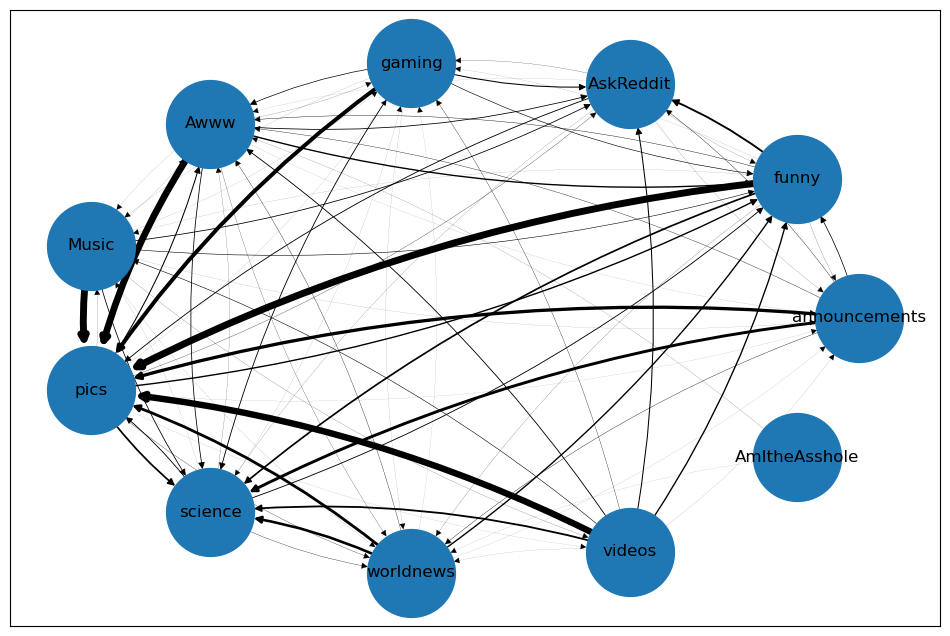

In [55]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

scale = 10

# Add the nodes to the graph
for sub in top_subreddits:
    G.add_node(sub)

# Add the edges to the graph, along with their weights
misguesses = {}
for source in top_subreddits:
    total = len(output[output['Actual'] == source])
    for target in top_subreddits:
        if source != target:
            misguessed = len(output[(output['Actual'] == source) & (output['Prediction'] == target)])
            misguesses[(source,target)] = misguessed/total
            if misguessed > .01:
                G.add_edge(source, target, weight = scale * misguessed/total)

# Draw the graph
pos = nx.circular_layout(G)
#nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
# Create a figure that is 8 inches wide and 6 inches tall
plt.figure(figsize=(12, 8))

edge_width = [d['weight'] for (u,v,d) in G.edges(data=True)]
#nx.draw_networkx_edges(G, pos, width=edge_width, edge_color='black', arrows=True, arrowsize=20)

nx.draw_networkx(G, pos,   width = edge_width, connectionstyle="arc3,rad=0.1", node_size = 4000)
#nx.draw(G, pos=pos)
plt.show()

In [ ]:
list(list(Results.items())[0][1].keys())